Title: Assignment - Project 2: Introduction to Natural Language Processing (NLP) with Disaster Tweets (Kaggle Challenge)

Name: Christoph Metzner

Student-ID: 000473394

Course: DSE511 - Introduction to Data Science I

# 1. Project and Data Description
This work functions as an introduction to Natural Language Processing (NLP) and developing a machine learning pipeline, using the dataset from the Kaggle Challenge *Natural Language Processing with Disaster Tweets*, available at https://www.kaggle.com/c/nlp-getting-started. In this challenge, several thousands of tweets are to be classified into two categories. That are the following: a) non-disaster tweets (label: 0) or b) disaster tweets (label: 1). The range of disaster can range from natural catastrophies like wildfires or flooding to shooting related incidents. In addition, an appropriate machine learning pipeline consisting of data cleaning, feature engineering, data splitting, hyperparameter tuning, and model training and evaluation has to be developed.

Since this is a kaggle challenge the test dataset does not contain any labels, i.e., the platform kaggle expects the competitor to submit their results directly onto their website for evaluation. Therefore,  only the labeled training dataset was used for this work. This dataset is split into a training (90%) and testing (10%) dataset. The models are trained and validated on the training set. Performance evaluation was done on the unseen testing dataset. The Function `GridSearchCV` from the library `sklearn` handles the hyperparameter tuning of the classification models.

The dataset has the following 4 features and column target represents the ground-truth label.
- id - a unique identifier for each tweet
- text - the text of the tweet
- location - the location the tweet was sent from (may include nan)
- keyword - a particular keyword from the tweet (may include nan)
- target - ground-truth labels of the tweets denoting either a real disaster (1) or not (0)

For this project, I decided to focus on the feature containing the text of the raw tweets to get started with NLP and to base the models performance only on how the tweets are preprocessed and the applied type of feature engineering. For feature engineering I am using the techniques *Bag-of-Words* and *term frequency–inverse document frequency* (tfidf). 

In [1]:
import os
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 100)  # Increase number of displayed rows when displayed
pd.options.display.max_colwidth = None  # Used to display the whole texts of the tweet.
import itertools


import kaggle  # import kaggle api to directly download dataset from
               # https://www.kaggle.com/c/nlp-getting-started/data
               # Please follow the required steps to set up kaggle api at https://www.kaggle.com/docs/api
import zipfile  # used to unzip zipped data

# Type Hints
from typing import List
from typing import Dict
from typing import Tuple
from typing import Union
from typing import TypeVar
PandasDataFrame = TypeVar('pandas.core.frame.DataFrame')
PandasSeries = TypeVar('pandas.core.series.Series')
SklearnClassifier = TypeVar('sklearn.linear_model._logistic.LogisticRegression',
                            'sklearn.svm._classes.SVC',
                            'sklearn.tree._classes.DecisionTreeClassifier')


# Imported Functions used for Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Model validation and hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

# Machine Learning Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Model evaluation metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix


# Plotting
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import seaborn as sns

# Module to take the elapsed time during training
import time

%matplotlib inline

## 1.1 Load raw data into Notebook
In this work, the raw datasets were downloaded directly from the kaggle website using the kaggle api. The introduction to setup the kaggle api can be found here: https://www.kaggle.com/docs/api.

In [2]:
def download_data_kaggle() -> Tuple[PandasDataFrame, PandasDataFrame]:
    """
    Function that downloads kaggle dataset using kaggle api.
    This function uses execution of a command line available at https://www.kaggle.com/c/nlp-getting-started/data.
    The command line should always be updated if different kaggle dataset is downloaded.
    
    Returns
    -------
    Two PandasDataFrame
        PandasDateFrame with train data, PandasDataFrame with test data.
    """
    
    # get path to current working directory
    cwd = os.getcwd()
    
    # get path to folder with stored data
    dir_data = os.path.join(cwd, 'data')
    
    # execute command line via kaggle api to download disaster tweet dataset zipped in "nlp-getting-started.zip"
    # this command skips download if most updated version is saved locally
    # key: data is the foldername the data is stored to
    # command -q represents quite mode
    
    # Change line here!
    !kaggle competitions download -c nlp-getting-started -p data -q
    
    # create variable for zip-file
    zip_file = 'nlp-getting-started.zip'
    
    # unzipping zipfile
    with zipfile.ZipFile(os.path.join(dir_data, zip_file), 'r') as zip_ref:
        zip_ref.extractall(dir_data)
    
    # Read csv data to pandas dataframe
    df_train = pd.read_csv(os.path.join(dir_data, 'train.csv'))  
    df_test = pd.read_csv(os.path.join(dir_data, 'test.csv'))  # Not used since testing data has no ground-truth labels
    
    return df_train, df_test

In [3]:
# Download the raw training data
# df_raw_test is not used for the purpose of this work
df_raw_train, df_raw_test = download_data_kaggle()

## 1.2 Data Description
The training dataset contains a total of 7613 samples/tweet split into 4342 (57%) non-disaster tweets and 3271 (43%) tweets about a disaster. Features `keyword` (61) and `location` (2533) contain missing values shown in parentheses. 

In [4]:
display(df_raw_train.sample(10))

,id,keyword,location,text,target
5485,7827,quarantine,NaN,@missambear your Tweet was quoted by @WIRED http://t.co/E90J3vJOLc,0
5206,7434,obliterated,NaN,Poway hcg diet- ensures mole obliterated whensoever nevermore comes above: sizYgwWF,0
2000,2875,damage,Unknown,@BradleyBrad47 the saw is fast af and does great damage i upgraded it a shitton and used it exclusively for a whole playthrough,0
5433,7752,police,Indonesia,Police kill hatchet-wielding gunman who opened fire inside Nashville movie theater: AåÊmiddle-aged manåÊarmed wi... http://t.co/tyD47NfL5x,1
6624,9488,terrorism,NaN,Pakistan Supreme Court endorses military courts for terrorism cases http://t.co/sZeapuEuvy,1
4591,6529,injuries,NaN,@Judson1360 @XTRA1360 O-line and pass rush. Rest of roster is stout barring injuries,0
2765,3973,devastation,Vancouver BC,Is This Country Latin America's Next 'Argentina': One week ago we reported on the economic devastation in he o... http://t.co/m2y9Ym3iF6,0
4206,5975,hazard,NaN,8/6/2015@1:32 PM: HAZARD IN HIGH TRAFFIC AREA at 5000 DEANS BRIDGE RD http://t.co/itZzKWfhG5,1
6278,8969,storm,New Delhi,@johngreen storm and silence by @RobThier_EN,0
983,1422,body%20bag,New York,New Ladies Shoulder Tote Handbag Faux Leather Hobo Purse Cross Body Bag Womens - Full readÛ_ http://t.co/uR7FeXszg4 http://t.co/wb8awobLcL,0


In [5]:
df_raw_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [6]:
print('\nNumber of Unique Values in each column.')
for col in df_raw_train.columns:
    num_unique = df_raw_train[col].nunique()
    if num_unique < 11:
        print(f'{col}: {num_unique} - {df_raw_train[col].unique()}')
    else:
        print(f'{col}: {num_unique}')


Number of Unique Values in each column.
id: 7613
keyword: 221
location: 3341
text: 7503
target: 2 - [1 0]


In [7]:
# Checking for any remaining missing values in both datasets
print('Missing Values per Column:')
print(df_raw_train.isna().sum())

Missing Values per Column:
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


### 1.2.1 Feature - text
Features `id`, `location`, and `keyword` were removed to focus only on the feature `text` containing the tweets. Throughout this work, different regular expression patterns for cleaning the tweets were tried. Updating the patterns helped to improve the performance of the models slightly.

The content of the individual tweets seem to be different in content and style; may include hyperlinks to other webpages.
Furthermore, they may include signal words for the location the tweet is about or even a "keyword" to describe the nature of the tweet (disaster or not).

In [8]:
# Dropping features 'id', 'location', and 'keyword'
df_raw_train = df_raw_train.drop(['id', 'location', 'keyword'], axis=1)

display(df_raw_train.sample(20))

,text,target
5399,I hear the mumbling i hear the cackling i got em scared shook panicking,0
2053,In my experience if you're always angry and critical as a pundit you are in grave danger of going off the rails. 1/,0
3399,@NoahCRothman Bore him with minutiae serve bad champagne. He may just explode.,0
5081,beforeitsnews : 3 former executives to be prosecuted in Fukushima nuclear disaster Û_ http://t.co/FgVN2vCrrX) http://t.co/kftVNU7nvf,1
6140,Super sweet and beautiful :) https://t.co/TUi9uwBvVp,0
2825,The year is 2065 and the national society of meme preservation has opened the first museum where memes and their origins are displaced,0
2945,Hundreds feared drowned after another Mediterranean asylum seeker boat sinking http://t.co/zsYkzj2bzG,1
7474,I'm a friggin wreck destiel sucks (read the vine description)\nhttps://t.co/MKX6Ux4OZt,0
6546,Nigerian boxer ?who survived sessions with Klitschko becomes famous on YouTube http://t.co/JSZZQsT3XS,0
6051,10News ? Water main break disrupts trolley service http://t.co/pAug7a68i0,1


#### 1.2.1.1 Tweet Length
The average length of a disaster tweet is roughly 15.17 elements and of 14.70 elements of a non-disaster tweet. In addition, very short and very long tweets are more likely to be non-disaster tweets. It seems that disaster tweets are prone to have similar medium size length. This could stem that different disasters are reported in similar fashion.

In [9]:
# Get number of elements per tweet
df_raw_train['text_count'] = df_raw_train.apply(lambda x: len(x.text.split()), axis=1)

# Average tweet length
print('Mean tweet length: ', df_raw_train['text_count'].mean())

# How many elements do the tweets have per category
print('Average tweet length per category:')
grp_count_category = df_raw_train.groupby('target').agg({'text_count': 'mean'}).reset_index()
display(grp_count_category)

Mean tweet length:  14.903585971364771
Average tweet length per category:


,target,text_count
0,0,14.704744
1,1,15.167533


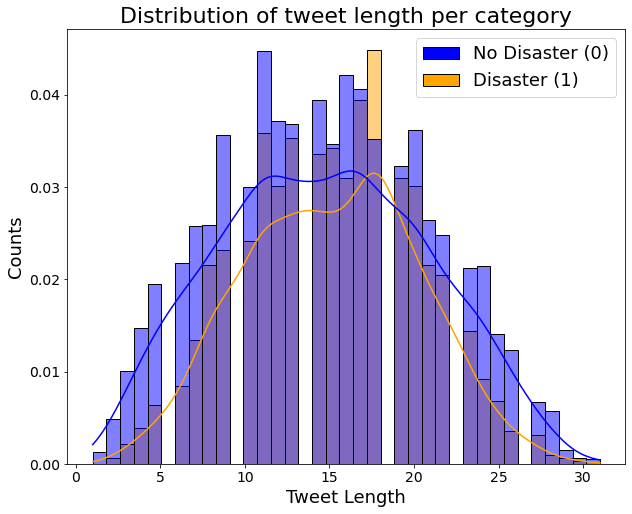

In [10]:
plt.figure(figsize=(10, 8))

# Define color palette for targets
palette = {
    0: 'b',
    1: 'orange',
}

sns.histplot(data=df_raw_train, x='text_count', hue='target', stat='density', kde=True, palette=palette)

# plot description
plt.title("Distribution of tweet length per category", fontsize=22)
plt.xlabel("Tweet Length", fontsize=18)
plt.xticks(fontsize=14, rotation=0)
plt.ylabel("Counts", fontsize=18)
plt.yticks(fontsize=14)

# Create custom legend objects
legend_elements = [Patch(facecolor='b', edgecolor='k', label='No Disaster (0)'),
                   Patch(facecolor='orange', edgecolor='k', label='Disaster (1)')]
plt.legend(handles=legend_elements, loc='upper right', fontsize=18)

plt.show()

### 1.2.2 Targets

Total number of tweets:  7613
Proportion of non disaster tweets: 0.57
Proportion of disaster tweets: 0.43


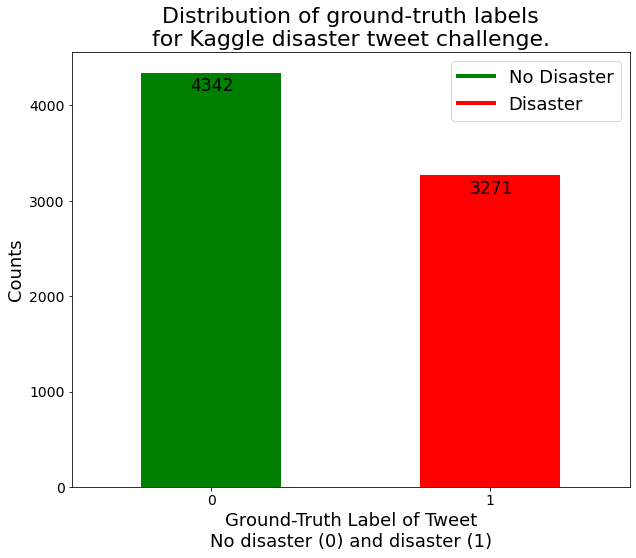

In [11]:
# Label distribution
# MAKE A GRAPH HERE
target_unique_counts = df_raw_train['target'].value_counts()
plt.figure(figsize=(10, 8))
target_unique_counts.plot(kind='bar', color = ['g', 'r'])

plt.title("Distribution of ground-truth labels\nfor Kaggle disaster tweet challenge.", fontsize=22)
plt.xlabel("Ground-Truth Label of Tweet\nNo disaster (0) and disaster (1)", fontsize=18)
plt.xticks(fontsize=14, rotation=0)
plt.ylabel("Counts", fontsize=18)
plt.yticks(fontsize=14)

legend_elements = [Line2D([0], [0], color='g', lw=4, label='No Disaster'),
                   Line2D([0], [0], color='r', lw=4, label='Disaster')]

plt.legend(handles=legend_elements, loc='upper right', fontsize=18)

plt.text(-0.075, 4150, '4342', fontsize=17)    
plt.text(0.925, 3070, '3271', fontsize=17)    

print("Total number of tweets: ", df_raw_train.shape[0])
print(f"Proportion of non disaster tweets: {df_raw_train['target'].value_counts()[0]/df_raw_train.shape[0]:.3}")
print(f"Proportion of disaster tweets: {df_raw_train['target'].value_counts()[1]/df_raw_train.shape[0]:.3}")

plt.show()

In [12]:
display(df_raw_train.sample(10))

,text,target,text_count
6748,73rd GOODE Water Ski National Championships will go on as planned next week http://t.co/PgKBT3MBAp. (Event w/ damage from a tornado on Mon),1,22
1222,Burning buildings? Media outrage? http://t.co/pHixZnv1YN,1,5
563,A young German stormtrooper engaged in the Battle of the Somme 1916. [800 ÌÑ 582 ] http://t.co/yxvMifLvc4,1,17
7184,@DwarfOnJetpack I guess I can say you and me might have one thing in common my biological father made me this way to be his weapon,0,26
4372,Governor allows parole for California school bus hijacker | Fresno Linked Local Network http://t.co/Sww0QsMxVM http://t.co/bcdP4gKokA,0,15
5034,@hazelannmac ooh now I feel guilty about wishing hatman out. I bet the mudslide was delicious!,0,16
7196,Pulse rifles after weapon tuning? http://t.co/UwObuUW2mK,0,6
600,#BreakingNews http://t.co/gAN14PW9TG FedEx no longer willing to transport research specimens of potential bioterÛ_ http://t.co/5n4hUsewLy,0,14
7098,#Amsterdam POV video captures violent landing at Amsterdam Airport Schiphol during a st... http://t.co/AlUMrGl40e http://t.co/8h2KCTFB8I,1,15
6566,Hiroshima survivors fight nuclear industry in Brazil Ì¢?? video http://t.co/GLZmGBM7w0,1,10


# 1.3 Preprocessing of Feature: `text`

The first step in natural langauge processing is filtering the strings for less informative characters. Such characters could be non-ascii characters, hyperlinks or urls, or any form of unnecessary whitespaces. Removing these characters will help to improve comparability of samples and model performance. The function `clean_tweet` was first developed to filter tweets. However, due to lower performance I decided to add additional heuristics to filter the tweets and created function `updated_clean_tweet`. The function includes several heuristics to filter for patterns using regular expression or transform all characters to lowercase.

In addition, to these heuristics I got inspired by the kaggle competitor *nxhong93* (https://www.kaggle.com/nxhong93/tweet-predict1) who developed a dictionary of common phrases to search for the abbreviated form and transform this form into non-abbreviated form. For example words like *wouldn't* are changed to *would not*. 

In [13]:
import re
import string

In [14]:
# Preliminary preprocessing function...
def clean_tweet(text: str) -> str:
    """Cleanse text (tweet) of characters and spaces.
        
    Parameters
    ----------
    text: str
        The unprocessed tweet containing non-ascii characters, unreadable word-number combinations.
    
    Returns
    -------
    str
        Cleaned text (tweet).
    """  
    
    # lower case
    text = text.lower()

    # remove twitter handle
    text = re.sub('@(?:\w)+', '', text)

    # remove hyperlinks
    text = re.sub('https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+/(?:[a-zA-Z0-9])+', '', text)

    # remove words containing numbers
    text = re.sub(r'[^\w\s]', '', text)
    
    # remove punctuation
    text = ' '.join(word.strip(string.punctuation) for word in text.split())

    # remove additional whitespaces and newline
    text = re.sub('\s+', ' ', text)

    # remove all non ascii symbols
    text = text.encode('ascii', 'ignore').decode(encoding='UTF-8')

    # remove stopwords
    text = " ".join(token for token in text.split() if token not in stopwords_en)
    
    return text

In [15]:
def updated_clean_tweet(text: str) -> str:
    """Cleanse text (tweet) of characters and spaces. Updated function.
        
    Parameters
    ----------
    text: str
        The unprocessed tweet containing non informative characters (e.g., non-ascii characters, unneccesary whitespaces).
    
    Returns
    -------
    str
        Cleaned text (tweet).
    """
    
    # remove url links
    pattern = r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+"
    text = re.sub(pattern, " ", text)

    # remove tweeter handles
    pattern = r"@[\w_]+"
    text = re.sub(pattern, " ", text)

    # remove money and time
    pattern = r"\$?[0-9]+:?"
    text = re.sub(pattern, " ", text)
    
    # remove numbers
    pattern = r"\d+"
    text = re.sub(pattern, " ", text)

    # remove ... or -- or _
    pattern = r"[.]{2,}|[-]{2,}|_"
    text = re.sub(pattern, " ", text)

    # remove special handles/??/| patterns
    pattern = r"@[\w']+|(\|)|[?]{2,}|(\\n){1,}"
    text = re.sub(pattern, " ", text)
    
    # remove words containing numbers
    pattern = r"[^\w\s]"
    text = re.sub(pattern, '', text)

    # convert text into ascii / remove any non-ascii symbol
    text = text.encode('ascii', 'ignore').decode(encoding='UTF-8')

    # remove additional whitespaces and newline
    text = re.sub('\s+', ' ', text)

    # remove ampersand words
    pattern = r"&[\w]+;?"
    text = re.sub(pattern, " ", text)

    # convert text into lowercase
    text = text.lower()

    return text

In [16]:
# check for missspelling
# Using ideas from https://www.kaggle.com/nxhong93/tweet-predict1 to clean the data even more
misspell_dict = {"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"couldnt" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"doesnt" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"havent" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"shouldnt" : "should not",
"that's" : "that is",
"thats" : "that is",
"there's" : "there is",
"theres" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"theyre":  "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not"}


def replace(match):
    return misspell_dict[match.group(0)]


def replace_misspelling(text):
    misspellings_re = re.compile('(%s)' % '|'.join(misspell_dict.keys()))

    return misspellings_re.sub(replace, text)

Copy and split the raw training dataframe into dataframe **X** containing the feature space and **y** containing the ground-truth labels.

In [17]:
X = df_raw_train.copy().iloc[:,:1]
y = df_raw_train.copy().iloc[:,1]

print('----Feature space used for classification----')
display(X.sample(3))
print('\n----Targets----')
display(y.sample(3))

----Feature space used for classification----


,text
2535,@KaiSeiw And then there's people like me where my whole people are named Desolation
451,it scares me that there's new versions of nuclear attack warnings like just knowing that governments still prepare for them
4883,This Friday!! Palm Beach County #Grindhouse Series one night screening of #TexasChainsawMassacre http://t.co/1WopsGbVvv @morbidmovies



----Targets----


5092    1
212     0
6029    0
Name: target, dtype: int64

In [18]:
# Apply function 'clean_tweet' to raw data to get cleaned text.
X['text'] = X.apply(lambda x: replace_misspelling(x.text), axis=1)
X['clean_text'] = X.apply(lambda x: updated_clean_tweet(x.text), axis=1)

print('--------Sample cleaned tweets--------')
display(X.sample(10))

--------Sample cleaned tweets--------


,text,clean_text
5138,US Navy Sidelines 3 Newest #Subs http://t.co/9WQixGMHfh,us navy sidelines newest subs
4428,Who is Tomislav Salopek the Islamic State's Most Recent Hostage? - http://t.co/wiQJERUktF,who is tomislav salopek the islamic states most recent hostage
1050,'Your body will heal the bags under your eyes will go away youÛªll be so happy youÛªll smile and really...' http://t.co/WuKcAlNQms,your body will heal the bags under your eyes will go away youll be so happy youll smile and really
5984,//screams in the distance// http://t.co/Cfe9HUQN0h,screams in the distance
1750,Motorcyclist bicyclist injured in Denver collision on Broadway: At least two people were taken to a localÛ_ http://t.co/ozK1QHJVfh,motorcyclist bicyclist injured in denver collision on broadway at least two people were taken to a local
5686,#news Britons rescued amid Himalaya floods http://t.co/kEPznhXHXd,news britons rescued amid himalaya floods
3942,Flood Prone Waterways In Westchester County Now Eligible For Millions In State Aid #NewYork - http://t.co/XSR2VUJyIz,flood prone waterways in westchester county now eligible for millions in state aid newyork
6070,i could die by falling in a sinkhole and I had still be blamed for it,i could die by falling in a sinkhole and i had still be blamed for it
5513,@__ScrambledEggs calling it now: KIA gets banned or quarantined before month's end,calling it now kia gets banned or quarantined before months end
3284,[Question] Is anybody else having this problem with the '7' circle in Epicentre? via /r/jailbreak http://t.co/48TPnmbJVG,question is anybody else having this problem with the circle in epicentre via rjailbreak


# 2. Data Analysis

In this section, the necessary machine learning pipeline functions for feature engineering/extraction (`feature_extraction`), initialization of the type of supervised classifier and the hyperparameter space for model parameter tuning (`init_classifiers`), performing hyperparameter tuning and model training (on training data) and evaluation (on testing data) (`ml_classification`), and automating all experiments (`run_experiment`).

The elapsed time during training and model evaluation was recorded for the purpose of comparison. The elapsed time includes hyperparameter tuning via GridSearchCV, fitting the best model on the training set, computing the training cv f1-score, and performance evaluation of the best model on the test data.

## 2.1 Feature Extraction
Two different types of feature extraction techniques were investigated during the analysis, which conceptually differ in their approach to assign a value of importance to a specific word (token) across the corpus. 

**Bag-of-Words**: the frequency of occurrence of each word is used as a feature for training a classifier.

**Term Frequency–Inverse Document Frequency (TFIDF)**: The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general.

In addition, different values for the hyperparameter *minimum document frequency* (min_df) were analyzed. This parameter determines how frequently a token must appear in the whole corpus to be considered as a feature.

In [19]:
def feature_extraction(
    X_train: PandasSeries,
    X_test: PandasSeries,
    min_df: int,
    fe_method: str = ['cv', 'tfidf']) -> Tuple[PandasDataFrame, PandasDataFrame]:
    
    """Extracts features from training data using either a) bag-of-words or b) TFIDF.
    An automatic filter for english stopwords is applied.
    
    Parameters
    ----------
    X_train: PandasSeries
        A pandas object containing one feature with cleaned texts of the tweets for the training dataset.
    X_test: PandasSeries
        A pandas object containing one feature with cleaned texts of the tweets for the testing dataset.
    min_df: integer
        Minimum number of occurences of a token across all tweets to be considered a feature.
    fe_method: str
        Feature extraction technique used to represent word frequency in text.
        
    Returns
    -------
    df_X_train_fit: PandasDataFrame
        fitted and transformed training dataset; feature engineering was fitted only on training data.
    df_X_test_fit: PandasDataFrame
        transformed testing dataset
    """
    
    if fe_method == 'cv': # Use bag-of-words as feature extraction technique
        feat_method = CountVectorizer(min_df=min_df, stop_words='english', ngram_range=(1, 2))
    elif fe_method =='tfidf': # Use term frequency-inverse document frequency
        feat_method = TfidfVectorizer(min_df=min_df, stop_words='english', ngram_range=(1, 2))
        
    X_train_fit = feat_method.fit_transform(X_train)
    X_test_fit = feat_method.transform(X_test)
    
    print('\nShape of Data after Feature Engineering')
    print(f'Shape of training data: {X_train_fit.shape}')
    print(f'Shape of test data: {X_test_fit.shape}')
    print(f'Size of vocabulary: {len(feat_method.vocabulary_)}\n')
    
    df_X_train_fit = pd.DataFrame(X_train_fit.toarray(), columns=feat_method.get_feature_names(), index=X_train.index)
    df_X_test_fit = pd.DataFrame(X_test_fit.toarray(), columns=feat_method.get_feature_names(), index=X_test.index)
    
    return df_X_train_fit, df_X_test_fit

## 2.2 Supervised Classification Algorithms
This is a binary, supervised classification task. Three different algorithms using different approach were used, which are the following: 1) Logistic Regression, 2) Support Vector Machine Classifier, and 3) Decision Tree. Due to the time-constraint and lack of performance of the local machine, only a linear SVM classifier was considered. The baseline model for the experiments is the model using logistic regression with bag-of-words and a minimum document frequency of 3.

For *logistic regression* and *support vector machine* the hyperparameter **C** regularizes the classifier with smaller values indicating stronger effect. In other words, for logistic regression if **C** is low, the complexity penalty is larger and is more likely to avoid overfitting. **C** for support vector machine indicates the degree of strictness to misclassification errors, i.e., lower value for C there is less penalty for misclassification. For the decision tree the **min_samples_split** and **min_samples_leaf** were identified as important hyperparameters to avoid overfitting the tree by requiring a minimum number of samples per split/leaf. This prevents the tree splitting extremely narrowly and learning every individual sample which in effect would lead to overfitting.

In [20]:
def init_classifiers(
    class_ind: str,
    seed: int) -> Tuple[SklearnClassifier, Dict[str, Union[int, float, str]]]:
    """ Function to initialize classifiers and the investigated hyperparamter space for tuning.
    
    Parameters
    ----------
    class_ind: str
        String variable indicating the classifier to be initialized
    seed: int
        Integer to set random_state for the purpose of reproducibility
    
    Returns
    -------
    clf: SklearnClassifier
        SklearnClassifier object
    param_grid: Dict
        Hyperparameter grid used for hyperparameter tuning
    """
                        
    # Logistic Regression Classifier
    if class_ind == 'lr':
        clf = LogisticRegression(random_state=seed, solver='liblinear') # solver 'liblinear' is required to compare l1 and l2
        param_grid = {
            'penalty': ['l1', 'l2'], #l1: lasso, l2: ridge
            'C' : [0.01, 0.1, 0.4, 0.5, 0.6, 1, 10, 100],  # smaller value indicate larger shrinkage
        }
    
    # Support Vector Machine Classifier
    elif class_ind == 'svc':
        clf = SVC(random_state=seed)
        param_grid = {
            'kernel': ['linear'],
            'C': [0.01, 0.1, 1, 10, 100], # C determines the strictness of the margins
        }
    
    # Random Forest Classifier
    elif class_ind == 'tree':
        clf = DecisionTreeClassifier(random_state=seed)
        param_grid = {
            'max_depth': [None, 50, 100],
            'max_features': [3, 5, "log2"],
            'min_samples_leaf': [2, 3],
            'min_samples_split': [5, 10, 15, 20],
        }

    return clf, param_grid

In [21]:
def ml_classification(
    X_train: PandasDataFrame,
    X_test: PandasDataFrame,
    y_train: PandasSeries,
    y_test: PandasSeries,
    classifier: SklearnClassifier,
    param_grid: Dict[str, Union[int, float, str]],
    cv_m: int) -> List[Union[float, List[float]]]:
    
    """This function performs hyperparameter tuning via the function GridSearchCV, takes the best estimator of the respective
    classifier for model evaluation. The splits during cross-validation are stratified.
    
    
    Parameters
    ----------
    X_train: PandasDataFrame
        Dataframe containing only the cleaned, preprocessed training data (tweets).
    X_test: PandasDataFrame
        Dataframe containing only the cleaned, preprocessed testing data (tweets).
    y_train: PandasSeries
        Series that contains the respective ground-truth labels for the training data.
    y_test: PandasSeries
        Series that contains the repsective ground-truth labels for the testing data.
    classifier: SklearnClassifier
        Variable that holds the respective initialized classifier.
    param_grid: dict
        A python dictionary that contains all parameters with their values for hyperparameter tuning.
    cv_m: int
        Variable that holds number of stratified splits (folds).
        
    Returns
    -------
    result_classifier: List
        A list containing all the performance metrics of the model.
    """                
    grid_clf = GridSearchCV(classifier, param_grid, cv=cv_m, scoring='f1', n_jobs=-1)
    grid_clf.fit(X_train, y_train)
    
    clf_best = grid_clf.best_estimator_
    clf_best.fit(X_train, y_train)
    
    # Get training score to identify under- und overfitting
    cv_score = cross_val_score(clf_best, X_train, y_train, cv=cv_m, scoring='f1', n_jobs=-1)
    
    y_pred = clf_best.predict(X_test)
    #y_pred_proba = clf_best.predict_proba(X_test)
    
    precision = precision_score(y_test, y_pred, average='binary', pos_label=1)
    recall = recall_score(y_test, y_pred, average='binary', pos_label=1)
    f1 = f1_score(y_test, y_pred, average='binary', pos_label=1)
    
    print(f'\nModel Performance for {clf_best}:')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1-Score: {f1}')

    # Plot a confusion matrix of the results
    print("\n--- Confusion matrix for test data ---")
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(conf_matrix)
    tp = conf_matrix[0][0]
    fp = conf_matrix[0][1]
    fn = conf_matrix[1][0]
    tn = conf_matrix[1][1]
    result_classifier = [clf_best, cv_score, np.mean(cv_score), precision, recall, f1, tp, fp, fn, tn]
    
    return result_classifier

In [22]:
def run_experiment(
    X: PandasDataFrame,
    y: PandasSeries,
    classifiers: List[str] = ['lr', 'svc', 'tree'],
    min_df: List[int] = [2, 3, 5, 10],
    fe_methods: List[str] = ['cv', 'tfdif']) -> PandasDataFrame:
    
    """This function runs the experiment by doing data splitting, feature engineering, and supervised classification.
    
    Parameters
    ----------
    
    X: PandasDataFrame
        Dataframe containing all samples in the dataset.
    y: PandasSeries
        Series containing all ground-truth labels of the dataset.
    classifiers: List[str]
        A list containing the str abbreviation of the three classifiers logistic regression ('lr'),
        support vector classifier ('svc'), and decision tree ('tree'). Can contain one to upto three classifiers.
    min_df: List[int]
        Integer determining the minimum document frequency of a token.
    fe_methods: List[str]
        A list containing the str abbreviation of the two applied feature engineering techniques.
        CountVectorizer or bag-of-words ('cv') and term frequency–inverse document frequency ('tfidf').
        
    Returns
    -------
    df_results: PandasDataFrame
        Dataframe containing the properties of the model (type of algorithm, min_df) and evaluated performance metrics.
    """
    
    seed = 42  # set seed for reproducibility
    np.random.seed(seed)

    k_fold = 5  # number of folds / splits when using cross-validation 
    cv_m = StratifiedKFold(n_splits=k_fold, shuffle=True) 

    test_size = 0.1  # Size of testing dataset partition
    
    # First: Split the raw dataset into a training and a testing dataset.
    # The testing dataset must not be used for anything but model evaluation.
    # Only use feature 'clean_text'
    X_train, X_test, y_train, y_test = train_test_split(
        X['clean_text'], y, test_size=test_size, random_state=seed)
    
    print('Get shape of training and testing data:\n')
    print(f'Shape of X_train: {X_train.shape}')
    print(f'Shape of y_train: {y_train.shape}')
    print(f'Shape of X_test: {X_test.shape}')
    print(f'Shape of y_test: {y_test.shape}\n')
    
    print(f'Show distribution of category labels for testing dataset:\n{y_test.value_counts()}\n')
    print('\n------------Experiments------------\n')
    

    experimental_combinations = list(itertools.product(fe_methods, min_df, classifiers))
    
    results_total = []
    sample_pred_total = []
    count = 1
    for experiment in experimental_combinations:
        results_classifier = []

        print(f'Experiment: {count} of 8')
        count += 1
        print(f'Classifier: {experiment[2]}')
        print(f'Feature Extraction Method: {experiment[0]}')
        print(f'Minimum Document Frequency: {experiment[1]}')
        df_X_train, df_X_test = feature_extraction(
            X_train=X_train,
            X_test=X_test,
            min_df=experiment[1],
            fe_method=experiment[0])          
            
            
        clf, param_grid = init_classifiers(class_ind=experiment[2], seed=seed)
        
        start = time.time()
        # Do classification with given parameters - get prediction results to identify which tweets were misclassified
        result_clf = ml_classification(
            X_train=df_X_train,
            X_test=df_X_test,
            y_train=y_train,
            y_test=y_test,
            classifier=clf,
            param_grid=param_grid,
            cv_m=cv_m)
        
        end = time.time()
        time_elapsed = end - start
        print(f'Elapsed Time: {time_elapsed}\n')
        
        
        results_classifier.append([experiment[2], experiment[0], experiment[1], time_elapsed])
        results_classifier.append(result_clf)   
        results_classifier = list(itertools.chain(*results_classifier))
        
        results_total.append(results_classifier)
        
        df_results = pd.DataFrame(
            results_total,
            columns=['model',
                    'fe_method',
                    'min_df',
                    'time_elapsed',
                    'best_fit',
                    'cv_scores_train',
                    'mean_cv_score_train',
                    'precision',
                    'recall',
                    'f1_score',
                    'tp',
                    'fp',
                    'fn',
                    'tn'])
        
        display(df_results)
        print('\n---------------------')
        
    return df_results

### 2.2.1 Run the Experiments
The following section deals with a rather comprehensive sequence of experiments. First experiments showed, that experiments using the logistic regression or the decision tree classifier take a rather trivial amount of time. Whereas, support vector machine based classification takes up to 40 minutes per one controlled experiment. These experienced times, of course, depend on the performance capabilities of the local machine.

The experiments included 

- 3 Algorithms
    - Logistic Regression (used as baseline)
    - Decision Tree
    - Support Vector Machine Classifier
- 2 Feature Engineering Techniques
    - Bag-of-Words (in sklearn - CountVectorizer)
    - Term Frequency–Inverse Document Frequency
- 4 Minimum Document Frequencies
    - 2
    - 3
    - 5
    - 10

resulting in a total of 24 (3x2x4) experiments.

After each sequence of experiments per algorithm the results are stored in a csv-file to enable later recovery without re-running the experiments again. This is helpful to allow easy access to the results.

In [23]:
# Not run in final submission due to time
# Results were stored and csv file
results_lr = run_experiment(X, y, classifiers=['lr'], min_df=[2, 3, 5, 10], fe_methods=['cv', 'tfidf'])
results_lr.to_csv("results_lr_ngrams.csv")

In [24]:
# Not run in final submission due to time
# Results were stored and csv file
results_tree = run_experiment(X, y, classifiers=['tree'],  min_df=[2, 3, 5, 10], fe_methods=['cv', 'tfidf'])
results_tree.to_csv("results_tree_ngrams.csv")

In [25]:
# Not run in final submission due to time
# Results were stored and csv file
results_svc = run_experiment(X, y, classifiers=['svc'],  min_df=[2, 3, 5, 10], fe_methods=['cv', 'tfidf'])
results_svc.to_csv("results_svc_ngrams.csv")

# 3. Results
In the following section, the main results of the experiments from section *2.2.1 Run the Experiments* are presented. For better readability, the best performances for the *F1 Score*, *Precision*, and *Recall* are boldfaced. The analysis is two-fold: 1) an analysis of the different classification algorithms and feature engineering techniques and 2) an error analysis of the misclassified tweets.

**Main takeaways of the experiments**

Best performing model per algorithm (more in section 3.1; bold numbers are overall best values):

| Classifier | Feature Engineering | Min. DF | F1 Score | Precision | Recall | Time Elapsed [min]| TP | FP | FN | TN |
| :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: |
| Support Vector Machine | TFIDF | 3 | **0.738854** | 0.794521 | 0.690476 | 37.5 |366 | 60 | 104 | 232 |
| Decision Tree | TFIDF | 5 | 0.702703 | 0.709091 | **0.696429** | 1 | 330 | 96 | 102 | 234 |
| Logistic Regression | Bag of Words | 2 | 0.733884 | 0.825279 | 0.660714 | 0.75 | 379 | 47 | 114 | 222 |
| Logistic Regression (Baseline) | Bag of Words | 3 | 0.725780 | 0.809524 | 0.657738 | 0.5 | 374 | 52 | 115 | 221 |
  

- The best performing model used the support vector machine algorithm. A siginifcant drawback of this algorithm is the computational complexity. In the experiments presented in this work, different kernel functions were not explored due to constraints in the computing performance of the local machine.
- Models based on logistic regression performed equally as good as the linear support vector machine with a significant reduction of computing time. Therefore, if resources are a constraining factor in deployment one might think about using logistic regression instead of a support vector machine.
- The best performing logistic regression model performed almost as good as the best overall model with an increased precision. A higher precision reflects less risk of false positives. In other words, if tweets were used, in part, to alarm the public for any kind of disaster the local government would have a lower chance to warn the public about a disaster while there is none. This may reduces unneccesary harm to people panicking. However, this comes at the expense of a lower recall, i.e., the abilitiy of the model detecting true disaster tweets in the first place. This might also not be desirable. 
- The baseline model performed better than all decision tree based models. (Section 3.1)
- The logistic regression models have lowest variance regarding the performance metrics f1-score, precision, and recall.

One might want to put care to the results below. More comprehensive experiments would need to take place to determine the underlying relationships between the algorithms, feature engineering techniques, and hyperparameter settings.

In [26]:
def maximum_value_in_column(column: List[str]):
    """ Function to boldface values in cell with maximum value per column.
    
    Parameters
    ----------
    column: str
        List containing column names that need to be boldfaced.
    """

    highlight = 'font-weight: bold'#; background-color: yellow;'
    default = ''

    maximum_in_column = column.max()

    return [highlight if v == maximum_in_column else default for v in column]

In [27]:
def load_results():
    """
    Function that loads results stored in csv-files.
    
    Returns
    -------
    PandasDataFrame
        Dataframe consisting results of all classifiers.
    """
    # Load the results to notebook
    res_lr = pd.read_csv('results_lr_ngrams.csv')
    res_tree = pd.read_csv('results_tree_ngrams.csv')
    res_svc = pd.read_csv('results_svc_ngrams.csv')

    # Concat the results
    results = pd.DataFrame(pd.concat([res_lr, res_tree, res_svc], axis=0, ignore_index=True)).drop('Unnamed: 0', axis=1)

    # Apply some changes to column ('model' and 'fe_method') content to be more explicit
    results['model'] = results['model'].map(
        {'lr': 'Logistic Regression',
        'svc': 'Support Vector Classifier',
        'tree': 'Decision Tree'},
        na_action=None)

    results['fe_method'] = results['fe_method'].map(
        {'cv': 'Bag of Words',
        'tfidf': 'TFIDF'})
        
    return results

In [28]:
results = load_results()

# dropping unneccessary columns for performance evaluation
results_metrics = results.drop(['best_fit', 'cv_scores_train', 'mean_cv_score_train'], axis=1).sort_index()

# Add column to indicate model index
results_metrics['model_index'] = range(0, len(results_metrics))

## 3.1 Results: Overall Model Performances
- Logistic Regression had least variance across all three performance metrics.


,model,fe_method,min_df,time_elapsed,precision,recall,f1_score,tp,fp,fn,tn,model_index
0,Logistic Regression,Bag of Words,2,53.325207,0.825279,0.660714,0.733884,379,47,114,222,0
1,Logistic Regression,Bag of Words,3,46.238700,0.809524,0.657738,0.725780,374,52,115,221,1
2,Logistic Regression,Bag of Words,5,29.218026,0.817164,0.651786,0.725166,377,49,117,219,2
3,Logistic Regression,Bag of Words,10,15.083306,0.798507,0.636905,0.708609,372,54,122,214,3
4,Logistic Regression,TFIDF,2,69.605767,0.817490,0.639881,0.717863,378,48,121,215,4
5,Logistic Regression,TFIDF,3,26.137541,0.811808,0.654762,0.724876,375,51,116,220,5
6,Logistic Regression,TFIDF,5,14.221686,0.823970,0.654762,0.729685,379,47,116,220,6
7,Logistic Regression,TFIDF,10,7.750563,0.793358,0.639881,0.708402,370,56,121,215,7
8,Decision Tree,Bag of Words,2,146.029613,0.774892,0.532738,0.631393,374,52,157,179,8
9,Decision Tree,Bag of Words,3,97.389226,0.697509,0.583333,0.635332,341,85,140,196,9


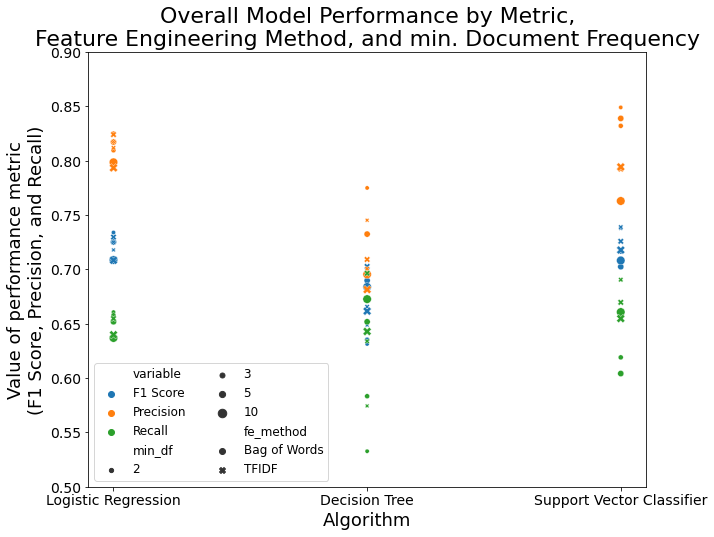

In [29]:
display(results_metrics.style.apply(maximum_value_in_column, subset=['precision', 'recall', 'f1_score'], axis=0))
results_metrics_melt = pd.melt(results_metrics, id_vars=['model', 'fe_method', 'min_df'], value_vars=['f1_score', 'precision', 'recall'])
# Renaming the names for the metrics
results_metrics_melt['variable'] = results_metrics_melt['variable'].map({
    'f1_score': 'F1 Score',
    'precision': 'Precision',
    'recall': 'Recall'
})    

plt.figure(figsize=(10, 8))

sns.scatterplot(data=results_metrics_melt, x='model', y='value', hue='variable', style='fe_method', size='min_df')


plt.title('Overall Model Performance by Metric,\nFeature Engineering Method, and min. Document Frequency', fontsize=22)
plt.xlabel('Algorithm', fontsize=18)
plt.xticks(fontsize=14)
plt.ylabel('Value of performance metric\n(F1 Score, Precision, and Recall)', fontsize=18)
plt.yticks(fontsize=14)
plt.ylim([0.5, 0.9])

plt.legend(loc='lower left', fontsize=12, ncol=2)

plt.show()

### Results: Top 5 Overall Models

,model,fe_method,min_df,time_elapsed,precision,recall,f1_score,tp,fp,fn,tn,model_index
21,Support Vector Classifier,TFIDF,3,2247.354155,0.794521,0.690476,0.738854,366,60,104,232,21
20,Support Vector Classifier,TFIDF,2,4283.278666,0.791809,0.690476,0.737679,365,61,104,232,20
0,Logistic Regression,Bag of Words,2,53.325207,0.825279,0.660714,0.733884,379,47,114,222,0
6,Logistic Regression,TFIDF,5,14.221686,0.823970,0.654762,0.729685,379,47,116,220,6
22,Support Vector Classifier,TFIDF,5,1198.183331,0.792254,0.669643,0.725806,367,59,111,225,22


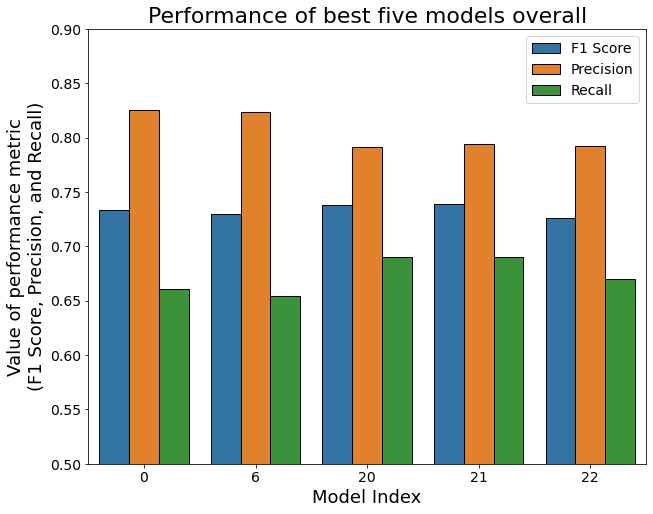

In [30]:
results_top_5_models = results_metrics.sort_values('f1_score', ascending=False).iloc[:5,:]
display(results_top_5_models.style.apply(maximum_value_in_column, subset=['precision', 'recall', 'f1_score'], axis=0))


# Melting the dataframe to make the values plotable with seaborn
results_top_5_models_melt = pd.melt(results_top_5_models, id_vars=['model_index'], value_vars=['f1_score', 'precision', 'recall'])

# Renaming the names for the metrics
results_top_5_models_melt['variable'] = results_top_5_models_melt['variable'].map({
    'f1_score': 'F1 Score',
    'precision': 'Precision',
    'recall': 'Recall'
})    
fig = plt.figure(figsize=(10,8))

sns.barplot(data=results_top_5_models_melt, x='model_index', y='value', hue='variable', edgecolor='k')

plt.title('Performance of best five models overall', fontsize=22)
plt.xlabel('Model Index', fontsize=18)
plt.xticks(fontsize=14)
plt.ylabel('Value of performance metric\n(F1 Score, Precision, and Recall)', fontsize=18)
plt.yticks(fontsize=14)
plt.ylim([0.5, 0.9])

plt.legend(loc='upper right', fontsize=14)

plt.show()

## 3.2 Results: Best Model per Algorithm
- Support vector machine and logistic regression performed comparable on the f1-score.
- Logistic regression performed better on precision but worse on recall.
- The highest recall among these models was discovered with the decision tree. But the overall performance of the decision is much worse than that of the logistic regression or support vector machine based models.

,model,fe_method,min_df,time_elapsed,precision,recall,f1_score,tp,fp,fn,tn,model_index
14,Decision Tree,TFIDF,5,60.625498,0.709091,0.696429,0.702703,330,96,102,234,14
0,Logistic Regression,Bag of Words,2,53.325207,0.825279,0.660714,0.733884,379,47,114,222,0
21,Support Vector Classifier,TFIDF,3,2247.354155,0.794521,0.690476,0.738854,366,60,104,232,21


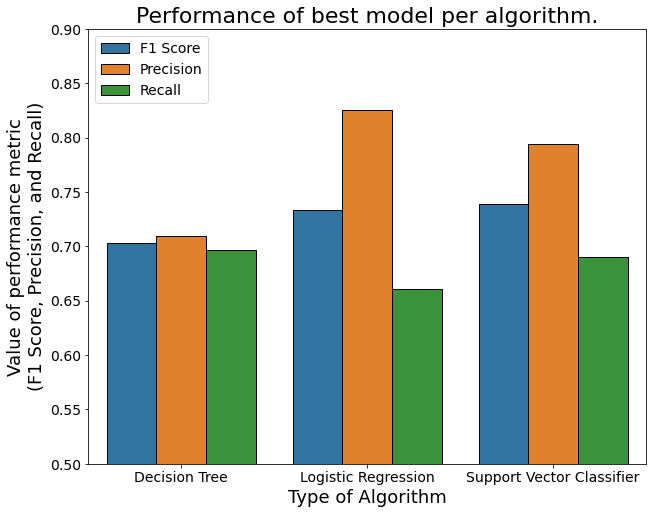

In [31]:
results_best_model_algo = results_metrics.loc[results_metrics.groupby(['model'])['f1_score'].idxmax()]
display(results_best_model_algo.style.apply(maximum_value_in_column, subset=['precision', 'recall', 'f1_score'], axis=0))

# Melting the dataframe to make the values plotable with seaborn
results_best_model_algo_melt = pd.melt(results_best_model_algo, id_vars=['model'], value_vars=['f1_score', 'precision', 'recall'])

# Renaming the names for the metrics
results_best_model_algo_melt['variable'] = results_best_model_algo_melt['variable'].map({
    'f1_score': 'F1 Score',
    'precision': 'Precision',
    'recall': 'Recall'
})    
fig = plt.figure(figsize=(10,8))

sns.barplot(data=results_best_model_algo_melt, x='model', y='value', hue='variable', edgecolor='k')

plt.title('Performance of best model per algorithm.', fontsize=22)
plt.xlabel('Type of Algorithm', fontsize=18)
plt.xticks(fontsize=14)
plt.ylabel('Value of performance metric\n(F1 Score, Precision, and Recall)', fontsize=18)
plt.yticks(fontsize=14)
plt.ylim([0.5, 0.9])

plt.legend(loc='upper left', fontsize=14)

plt.show()

## 3.3 Results: Model Performance by feature engineering and minimum document frequency
- In this section, the three performance metrics F1-Score, precision, and recall are compared based on the feature engineering technique and the minimum document frequency.
- In general, the f1-scores for the two feature engineering techniques are pretty similar. However, for the document frequency 2, 3, and 5 *tfidf* tends to perform better than bag-of-words.
- The precision metric is higher for models using bag-of-words for min. document frequency of 2, 3, and 5.
- The recall metric is higher for models using tfidf for min. document frequency of 2, 3, and 5.
- Overall it seems, that models using tfidf with a min. document of frequency of 3 and 5 perform marginally better than models with bag-of-words. 
- There is no real difference between model performance and the choice of feature engineering technique when a min. document frequency of 2 and 10 was selected.
-

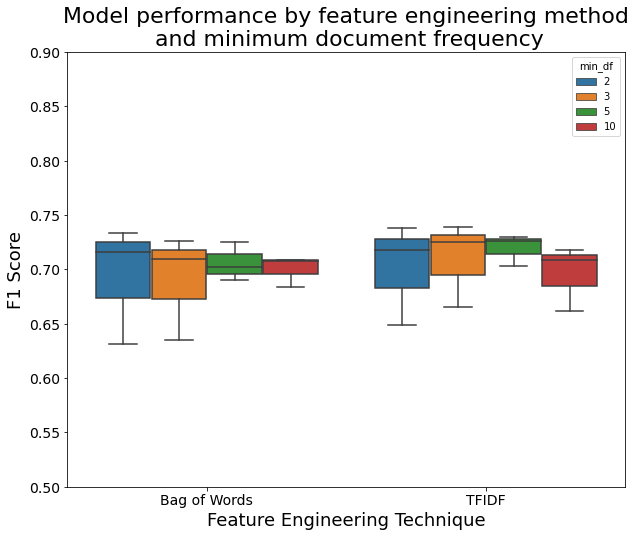

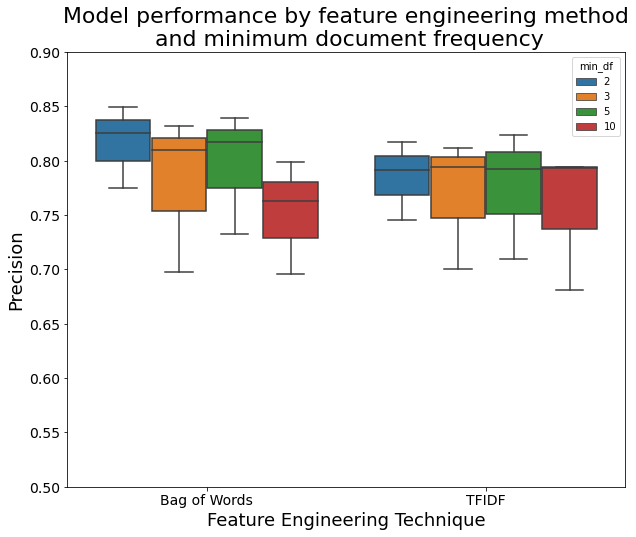

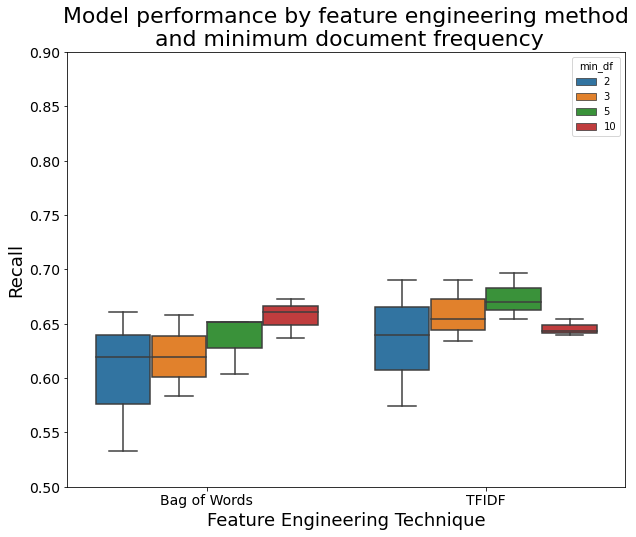

In [32]:
results_fe_mindf = results_metrics.groupby(['fe_method', 'min_df']).mean().drop('model_index', axis=1)
display(results_fe_mindf.style.apply(maximum_value_in_column, subset=['precision', 'recall', 'f1_score'], axis=0))

plt.figure(figsize=(10, 8))

sns.boxplot(x='fe_method', y='f1_score', data=results_metrics, hue='min_df')
plt.title('Model performance by feature engineering method\n and minimum document frequency', fontsize=22)
plt.xlabel('Feature Engineering Technique', fontsize=18)
plt.xticks(fontsize=14)
plt.ylabel('F1 Score', fontsize=18)
plt.yticks(fontsize=14)
plt.ylim([0.5, 0.9])

plt.show()

plt.figure(figsize=(10, 8))

sns.boxplot(x='fe_method', y='precision', data=results_metrics, hue='min_df')
plt.title('Model performance by feature engineering method\n and minimum document frequency', fontsize=22)
plt.xlabel('Feature Engineering Technique', fontsize=18)
plt.xticks(fontsize=14)
plt.ylabel('Precision', fontsize=18)
plt.yticks(fontsize=14)
plt.ylim([0.5, 0.9])


plt.show()

plt.figure(figsize=(10, 8))

sns.boxplot(x='fe_method', y='recall', data=results_metrics, hue='min_df')
plt.title('Model performance by feature engineering method\n and minimum document frequency', fontsize=22)
plt.xlabel('Feature Engineering Technique', fontsize=18)
plt.xticks(fontsize=14)
plt.ylabel('Recall', fontsize=18)
plt.yticks(fontsize=14)
plt.ylim([0.5, 0.9])

plt.show()

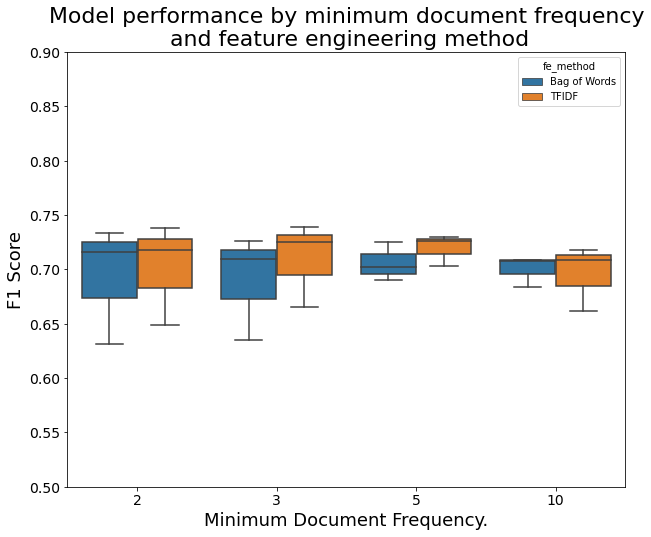

In [33]:
plt.figure(figsize=(10, 8))

sns.boxplot(x='min_df', y='f1_score', data=results_metrics, hue='fe_method')
plt.title('Model performance by minimum document frequency\n and feature engineering method', fontsize=22)
plt.xlabel('Minimum Document Frequency.', fontsize=18)
plt.xticks(fontsize=14)
plt.ylabel('F1 Score', fontsize=18)
plt.yticks(fontsize=14)
plt.ylim([0.5, 0.9])

plt.show()

## 3.4 Results: Time Elapse vs F1-Score by Algorithm/min_df/feature_engineering
- The fastest algorithm is logistic regression, followed closely by the decision tree, and support vector machine. Support vector machine takes a non-trivial longer time to train the model.
- Minimum document frequency determines the number of extracted features from the tweets. A lower value means more features, which leads to longer training times.
- Comparing the graph there is no clear answer which feature engineering technique causes to the model to train longer. It seems for the logistic regression model, that bag-of-words is faster than tfidf. However, for decision tree and support vector machine tfidf is faster. Apparently, decision tree and svm can deal better with fractions than logistic regression. 

In [34]:
results_metrics['time_elapsed'] = results_metrics.apply(lambda x: x.time_elapsed, axis=1)

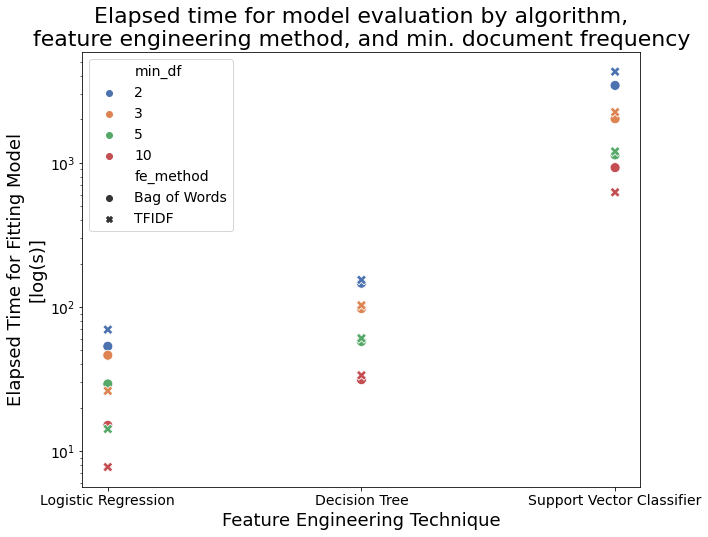

In [35]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data=results_metrics, y='time_elapsed', x='model', hue='min_df', style='fe_method', palette='deep', s=100)

plt.title('Elapsed time for model evaluation by algorithm,\nfeature engineering method, and min. document frequency', fontsize=22)
plt.xlabel('Feature Engineering Technique', fontsize=18)
plt.xticks(fontsize=14)
plt.ylabel('Elapsed Time for Fitting Model\n[log(s)]', fontsize=18)
plt.yticks(fontsize=14)
plt.yscale('log')

plt.legend(fontsize=14)

plt.show()

# 4. Error Analysis: Confusion matrix and examplary wrong tweets
In this section, the confusion matrices for the top model per algorithm were analyzed to identify how differently the tweets were treated during classification.


The best models were re-run to check if the experiments are reproducible.


In [36]:
results_best_model_algo2 = results.loc[results.groupby(['model'])['f1_score'].idxmax()].drop(['cv_scores_train', 'mean_cv_score_train'], axis=1)
display(results_best_model_algo2)

,model,fe_method,min_df,time_elapsed,best_fit,precision,recall,f1_score,tp,fp,fn,tn
14,Decision Tree,TFIDF,5,60.625498,"DecisionTreeClassifier(max_features='log2', min_samples_leaf=2,\n min_samples_split=10, random_state=42)",0.709091,0.696429,0.702703,330,96,102,234
0,Logistic Regression,Bag of Words,2,53.325207,"LogisticRegression(C=0.4, random_state=42, solver='liblinear')",0.825279,0.660714,0.733884,379,47,114,222
21,Support Vector Classifier,TFIDF,3,2247.354155,"SVC(C=1, kernel='linear', random_state=42)",0.794521,0.690476,0.738854,366,60,104,232


In [37]:
def run_single_experiment(
    X: PandasDataFrame,
    y: PandasSeries,
    clf: SklearnClassifier,
    min_df: int,
    fe_method: str = ['cv', 'tfidf']) -> Tuple[List[float], List[int], List[int], List[int]]:
    """
    Function that runs individual experiments.
    
    Parameters
    ----------    
    X: PandasDataFrame
        Dataframe containing all samples in the dataset.
    y: PandasSeries
        Series containing all ground-truth labels of the dataset.
    classifiers: SklearnClassifier
        Classifier object from sklearn library
    min_df: int
        Integer determining the minimum document frequency of a token.
    fe_methods: str
        String abbreviation for the feature engineering technique.
        CountVectorizer or bag-of-words ('cv') and term frequency–inverse document frequency ('tfidf').
        
    
    Returns
    -------
    result_classifier: list(float)
        List containg results for performance metrics
    df_X_test.index: list(int)
        List containing sample id's of test set
    y_test: list(int)
        List containing ground-truth labels of test set
    y_pred: list(int)
        List containing predicted labels for test set
    
    """
    seed = 42  # set seed for reproducibility
    np.random.seed(seed)

    k_fold = 5  # number of folds / splits when using cross-validation 
    cv_m = StratifiedKFold(n_splits=k_fold, shuffle=True) 

    test_size = 0.1  # Size of testing dataset partition
    
    # First: Split the raw dataset into a training and a testing dataset.
    # The testing dataset must not be used for anything but model evaluation.
    # Only use feature 'clean_text'
    X_train, X_test, y_train, y_test = train_test_split(
        X['clean_text'], y, test_size=test_size, random_state=seed)
    
    print('Get shape of training and testing data:\n')
    print(f'Shape of X_train: {X_train.shape}')
    print(f'Shape of y_train: {y_train.shape}')
    print(f'Shape of X_test: {X_test.shape}')
    print(f'Shape of y_test: {y_test.shape}\n')
    
    df_X_train, df_X_test = feature_extraction(
        X_train=X_train,
        X_test=X_test,
        min_df=min_df,
        fe_method=fe_method)
    
    clf.fit(df_X_train, y_train)

    y_pred = clf.predict(df_X_test)
    
    precision = precision_score(y_test, y_pred, average='binary', pos_label=1)
    recall = recall_score(y_test, y_pred, average='binary', pos_label=1)
    f1 = f1_score(y_test, y_pred, average='binary', pos_label=1)
    
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1-Score: {f1}')

    # Plot a confusion matrix of the results
    print("\n--- Confusion matrix for test data ---")
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(conf_matrix)
    tp = conf_matrix[0][0]
    fp = conf_matrix[0][1]
    fn = conf_matrix[1][0]
    tn = conf_matrix[1][1]
    result_classifier = [f1, precision, recall, tp, fp, fn, tn]
    
    return result_classifier, df_X_test.index, y_test, y_pred

## 4.1 Run the best Model per Algorithm again to check Reproducibility
The experiments are reproducible since the results in the following experiments are the same as from section *3.2 Results: Best Model per Algorithm*. 

I also decided to recover the individual information of the falsely predicted samples concering their prediction condition (e.g., TP, FP, FN, TN). 

In [38]:
# Update maximum display rows of a pandas dataframe to None, i.e., show all rows in a dataframe
pd.set_option('display.max_rows', None)

# Init best three models
clf_tree = DecisionTreeClassifier(max_features='log2', min_samples_leaf=2, min_samples_split=10, random_state=42)
clf_svc = SVC(C=1, kernel='linear', random_state=42)
clf_lr = LogisticRegression(C=0.4, random_state=42, solver='liblinear')

In [39]:
# Run best logistic regression model
# Returning the results, sampled indices, ground-truth labels for test data, and predicted label for test data
result_lr, test_sample_id_lr, y_test_lr, y_pred_lr = run_single_experiment(X=X, y=y, clf=clf_lr, min_df=2, fe_method='cv')
display(result_lr)

Get shape of training and testing data:

Shape of X_train: (6851,)
Shape of y_train: (6851,)
Shape of X_test: (762,)
Shape of y_test: (762,)


Shape of Data after Feature Engineering
Shape of training data: (6851, 9535)
Shape of test data: (762, 9535)
Size of vocabulary: 9535

Precision: 0.8252788104089219
Recall: 0.6607142857142857
F1-Score: 0.7338842975206611

--- Confusion matrix for test data ---
[[379  47]
 [114 222]]


[0.7338842975206611, 0.8252788104089219, 0.6607142857142857, 379, 47, 114, 222]

In [40]:
# Run best support vector machine model
# Returning the results, sampled indices, ground-truth labels for test data, and predicted label for test data
result_svc, test_sample_id_svc, y_test_svc, y_pred_svc= run_single_experiment(X=X, y=y, clf=clf_svc, min_df=3, fe_method='tfidf')
display(result_svc)

Get shape of training and testing data:

Shape of X_train: (6851,)
Shape of y_train: (6851,)
Shape of X_test: (762,)
Shape of y_test: (762,)


Shape of Data after Feature Engineering
Shape of training data: (6851, 5497)
Shape of test data: (762, 5497)
Size of vocabulary: 5497

Precision: 0.7945205479452054
Recall: 0.6904761904761905
F1-Score: 0.7388535031847133

--- Confusion matrix for test data ---
[[366  60]
 [104 232]]


[0.7388535031847133, 0.7945205479452054, 0.6904761904761905, 366, 60, 104, 232]

In [41]:
# Run best decision tree model
# Returning the results, sampled indices, ground-truth labels for test data, and predicted label for test data
result_tree, test_sample_id_tree, y_test_tree, y_pred_tree = run_single_experiment(X=X, y=y, clf=clf_tree, min_df=5, fe_method='tfidf')
display(result_tree)

Get shape of training and testing data:

Shape of X_train: (6851,)
Shape of y_train: (6851,)
Shape of X_test: (762,)
Shape of y_test: (762,)


Shape of Data after Feature Engineering
Shape of training data: (6851, 2997)
Shape of test data: (762, 2997)
Size of vocabulary: 2997

Precision: 0.7090909090909091
Recall: 0.6964285714285714
F1-Score: 0.7027027027027026

--- Confusion matrix for test data ---
[[330  96]
 [102 234]]


[0.7027027027027026, 0.7090909090909091, 0.6964285714285714, 330, 96, 102, 234]

In [42]:
pred_res = pd.DataFrame({'sample_id': test_sample_id_tree,
                        'y_true': y_test_tree,
                        'y_pred_lr': y_pred_lr,
                        'y_pred_svc': y_pred_svc,
                        'y_pred_tree': y_pred_tree})

In [54]:
def get_pred_condition(y_true, y_pred):
    if y_true == 1:
        if y_pred == y_true:
            return 'TP'
        else:
            return 'FN'
    elif y_true == 0:
        if y_pred == y_true:
            return 'TN'
        else:
            return 'FP'
        
# Add prediction condition label to make the type of prediction clearer.
pred_res['pred_cond_lr'] = pred_res.apply(lambda x: get_pred_condition(x.y_true, x.y_pred_lr), axis=1)
pred_res['pred_cond_svc'] = pred_res.apply(lambda x: get_pred_condition(x.y_true, x.y_pred_svc), axis=1)
pred_res['pred_cond_tree'] = pred_res.apply(lambda x: get_pred_condition(x.y_true, x.y_pred_tree), axis=1)

## 4.2 Error Analysis of Prediction of Disaster Tweets
In the final section of this work, an error analysis of the prediction of the disaster tweets was conducted. The goal here was to identify, why certain tweets or subsets of tweets were not correctly classified. I decided to investigate tweets, that were not correctly classified by all models or by only one for split into false positives and false negatives. A total of 8 subsets.

In [44]:
# Creating columns with conditions for filtering 
for sample in pred_res.sample_id.tolist():   
    n = pred_res.loc[sample,'pred_cond_lr':'pred_cond_tree'].nunique()
    pred_res.loc[sample,'n_unique'] = n

In [45]:
# The following code is a more hardcoded version of what I wanted to accomplish. At the time of coding
# I did not know a better way to accomplish this differentiation into smaller groups. Do you perhaps know a better, more
# generalizable way to accomplish the same thing? 

samples_all_fp = []
samples_all_fn = []
samples_lr_fp = []
samples_lr_fn = []
samples_svc_fp = []
samples_svc_fn = []
samples_tree_fp = []
samples_tree_fn = []

for sample in pred_res.sample_id.tolist():
    current_sample = pred_res.loc[sample,:]
    n_unique = pred_res.loc[sample, 'n_unique']
    y_true = pred_res.loc[sample,'y_true']
    y_pred_lr = pred_res.loc[sample, 'y_pred_lr']
    y_pred_svc = pred_res.loc[sample, 'y_pred_svc']
    y_pred_tree = pred_res.loc[sample, 'y_pred_tree']

    
    
    # Checking whether all models were either correct or wrong
    if n_unique == 1:
        # checking for false negative
        if y_true == 1:
            # if y_true is not y_pred for logistic regression than it is not equal to the other models predictions
            if y_true != y_pred_lr:
                samples_all_fn.append(current_sample)
        # checking for false positive
        elif y_true == 0:
            # if y_true is not y_pred for logistic regression than it is not equal to the other models predictions
            if y_true != y_pred_lr:
                samples_all_fp.append(current_sample)         
    elif n_unique == 2:
        # checking for false negative
        if y_true == 1:
            if y_true != y_pred_lr:
                if y_pred_lr != y_pred_svc and y_pred_lr != y_pred_tree:
                    samples_lr_fn.append(current_sample)
            elif y_true != y_pred_svc:
                if y_pred_svc != y_pred_lr and y_pred_svc != y_pred_tree:
                    samples_svc_fn.append(current_sample)
            elif y_true != y_pred_tree:
                if y_pred_tree != y_pred_lr  and y_pred_tree != y_pred_svc:
                    samples_tree_fn.append(current_sample)
        elif y_true == 0:
            if y_true != y_pred_lr:
                if y_pred_lr != y_pred_svc and y_pred_lr != y_pred_tree:
                    samples_lr_fp.append(current_sample)
            elif y_true != y_pred_svc:
                if y_pred_svc != y_pred_lr and y_pred_svc != y_pred_tree:
                    samples_svc_fp.append(current_sample)
            elif y_true != y_pred_tree:
                if y_pred_tree != y_pred_lr  and y_pred_tree != y_pred_svc:
                    samples_tree_fp.append(current_sample)

        

df_all_fp = pd.DataFrame(samples_all_fp)
df_all_fn = pd.DataFrame(samples_all_fn)

df_lr_fp = pd.DataFrame(samples_lr_fp)
df_lr_fn = pd.DataFrame(samples_lr_fn)
df_svc_fp = pd.DataFrame(samples_svc_fp)
df_svc_fn = pd.DataFrame(samples_svc_fn)
df_tree_fp = pd.DataFrame(samples_tree_fp)
df_tree_fn = pd.DataFrame(samples_tree_fn)

### 4.2.1 Tweets were all models made false predictions
It seems, that using either bag-of-words or tfidf for feature extraction from the tweets makes the models focus only on the individual words presence within the corpus of text. In other words, the models learn to connect certain keywords with a distinct type of tweet based on importance. Exemplary keywords for disaster tweets are *flooding*, *heat wave*, or *storm*. If these keywords are present in a tweet then there is a higher chance that this tweet is labeled as a disaster. One drawback of these feature engineering techniques is the lack of contextual understanding of the keyword. Was this keyword used in a positive or negative way. Furthermore, using a technique that allows for contextual understanding would provide better understanding of the typical sentence structure of a non-disaster/disaster tweet.

#### 4.2.2.1 False Positives
The models classified these tweets as disaster tweets, since they contain keywords like that usually indicate a natural disaster. But in the present contexts of the tweets, these keywords were used in a positive way by the authors of the tweets. The models learned to associate such keywords with disaster tweets during training. 

In [46]:
all_fp_idx = df_all_fp.sample_id.tolist()
X.loc[all_fp_idx].sample(10)

,text,clean_text
3973,@crabbycale OH MY GOD THE MEMORIES ARE FLOODING BACK,oh my god the memories are flooding back
4273,Cherry print + matching lipstick (just rediscovered NarsÛª Û÷Heat WaveÛª).?? by @emilyschuman http://t.co/4eGh1G1Jk7,cherry print matching lipstick just rediscovered nars heat wave by
1971,1970 Mercury Cyclone GT Hood Moulding Very NICE CORE Cobra Jet 429CJ GT http://t.co/jOBVBvKFnZ http://t.co/C8zPmZhTDE,mercury cyclone gt hood moulding very nice core cobra jet cj gt
5080,Is your team ready for a natural disaster a violent client or power outage? Contact Ready Vet to design... http://t.co/u2NJPoR39K,is your team ready for a natural disaster a violent client or power outage contact ready vet to design
5459,#helpme what do I do? My friend has been ticketed by Police in Wayne County Michigan into never- sending poverty cycle. How do I help him?,helpme what do i do my friend has been ticketed by police in wayne county michigan into never sending poverty cycle how do i help him
2991,@NWSPocatello BG-16: So far brunt of storm just to our north. Grayed out w/ dust &amp; rain to N blue sky interspersed w/ clouds to S.,bg so far brunt of storm just to our north grayed out w dust amp rain to n blue sky interspersed w clouds to s
5444,UNWANTED PERSON at 200 BLOCK OF SE 12TH AVE PORTLAND OR [Portland Police #PP15000266818] 17:10 #pdx911,unwanted person at block of se th ave portland or portland police pp pdx
3358,I got evacuated from the cinema 30 mins through Inside Out\nKill me please,i got evacuated from the cinema mins through inside out kill me please
4270,Chilli heat wave Doritos never fail!,chilli heat wave doritos never fail
1174,@BloopAndABlast Because I need to know if I'm supposed to throw myself off a bridge for a #Collapse or plan the parade. There is no both,because i need to know if im supposed to throw myself off a bridge for a collapse or plan the parade there is no both


#### 4.2.2.2 False Negatives
Even though some of the keywords are present as for example sample 6261 with *storm*, the rest of the sentence may have indicated the models to be a tweet not about a disaster. This is similar as for the false positives, the models did not take the meaning of the sentence into account.

In [47]:
all_fn_idx = df_all_fn.sample_id.tolist()
X.loc[all_fn_idx].sample(10)

,text,clean_text
1737,Cyclist who collided with runner on Roanoke greenway wins $300000 civil verdict - Roanoke Times: Cyclist who c... http://t.co/E2WfGp8JHk,cyclist who collided with runner on roanoke greenway wins civil verdict roanoke times cyclist who c
3770,I just checked in! ÛÒ at On Fire on @ZomatoAUS #LoveFood http://t.co/9l5kqykrbG,i just checked in at on fire on lovefood
7220,I'm sorry but if you have to resort to weapons to settle something you are a pussy win or lose take your shit like a man &amp; leave it at that,im sorry but if you have to resort to weapons to settle something you are a pussy win or lose take your shit like a man amp leave it at that
2977,Boy saves autistic brother from drowning: A nine-year-old in Maine dove into a pool to save his autistic brother from drowning,boy saves autistic brother from drowning a nineyearold in maine dove into a pool to save his autistic brother from drowning
2644,So you have a new weapon that can cause un-imaginable destruction.,so you have a new weapon that can cause unimaginable destruction
2022,@GettingLost @JennEllensBB @Muncle_jim It said they had superficial wounds and it was the pepper spray that did the most damage.,it said they had superficial wounds and it was the pepper spray that did the most damage
6513,A country Chim can survive!,a country chim can survive
6261,So this storm just came out of no where. .fuck me its cool,so this storm just came out of no where fuck me its cool
733,@KatRamsland Yes I'm a bleeding heart liberal.,yes im a bleeding heart liberal
6212,@PianoHands You do not know because you do not smoke. The way to make taxis and buses come is to light a cigarette to smoke while you wait.,you do not know because you do not smoke the way to make taxis and buses come is to light a cigarette to smoke while you wait


### 4.2.2 Tweets were exactly one model made false predictions
A comprehensiv error analysis would demand to compare the falsely labeled tweets with the correctly labeled tweets to identify different patterns. However, for the sake of brevity the following section serves only as a visual represenation of the falsely predicted tweets by the individual algorithms.

#### 4.2.2.1 Logistic Regression: False Positives

In [48]:
lr_fp_idx = df_lr_fp.sample_id.tolist()
X.loc[lr_fp_idx]

,text,clean_text
6755,Guys he can run so fast he creates a tornado WITHOUT BREAKING A SWEAT. He makes Superman look like a slowpoke. He can be a POC.,guys he can run so fast he creates a tornado without breaking a sweat he makes superman look like a slowpoke he can be a poc
1078,@dopeitsval ahh you are bomb baby ??,ahh you are bomb baby
748,@mfalcon21 go look. Just blew it up w atomic bomb.,go look just blew it up w atomic bomb
6161,I hate this damn Milwaukee IndyFest. All the cars sound like a really long tornado siren going off and it woke me up from my nap,i hate this damn milwaukee indyfest all the cars sound like a really long tornado siren going off and it woke me up from my nap


#### 4.2.2.2 Logistic Regression: False Negative

In [49]:
lr_fn_idx = df_lr_fn.sample_id.tolist()
X.loc[lr_fn_idx]

,text,clean_text
4698,Method in contemplation of incident an leading bridal landslide: wiWNpFXA http://t.co/xysNXUM29T,method in contemplation of incident an leading bridal landslide wiwnpfxa
6981,950. If a landslide tumbles down todayI'm on your side\n\nAnd if a twister sweeps it all away-\n\nYOU'RE ON YOUR OWN BITCH!*runs into distance*,if a landslide tumbles down todayim on your side and if a twister sweeps it all away youre on your own bitchruns into distance
3616,EXCLUSIVE: In 179 fatalities involving on-duty NYPD cops in 15 years only 3åÊÛ_ http://t.co/Cn1joMMUGH,exclusive in fatalities involving onduty nypd cops in years only
6540,@TheSmallClark 'He'll kill me instead if he survived the shot. I do not exactly know. I fled the scene and pulled the trigger with---,hell kill me instead if he survived the shot i do not exactly know i fled the scene and pulled the trigger with
3475,Large explosion rocks aluminum plant in southeast Missouri Re:Naomi-No Logo http://t.co/0WdsEIHYQu,large explosion rocks aluminum plant in southeast missouri renaomino logo
2142,@Eazzy_P we will never know what would have happened but the govt seemed to think that their beliefs warranted the deaths of innocent japs,we will never know what would have happened but the govt seemed to think that their beliefs warranted the deaths of innocent japs
4031,IT STARTS A FOREST FIRE THAT CANNOT BE PUT OUT. http://t.co/3STfmN26r9,it starts a forest fire that cannot be put out
354,Salvation Army hosts rally to reconnect fathers with children: The Salvation Army is hosting a back to school rallyÛ_ http://t.co/rDjpor3AZg,salvation army hosts rally to reconnect fathers with children the salvation army is hosting a back to school rally
73,BigRigRadio Live Accident Awareness,bigrigradio live accident awareness


#### 4.2.2.3 Support Vector Classifier: False Positive

In [50]:
svc_fp_idx = df_svc_fp.sample_id.tolist()
X.loc[svc_fp_idx]

,text,clean_text
4928,Magic City Mayhem: Kissimmee adventures ? Aug. 5 2015 http://t.co/FpYrU5GOLh,magic city mayhem kissimmee adventures aug
4100,Kevin Tan says hail to the chefs - Û_ and Green Pastures which features sustainable and organic cooking.... http://t.co/D9xVuvp9s6,kevin tan says hail to the chefs and green pastures which features sustainable and organic cooking
1952,#Camera #Art #Photography http://t.co/TJGxDc3D5p #0215 New BoltåÊCyclone DR PP-400DR Dual Outlet Power PackåÊFor External Camera Flash\n\n$30Û_,camera art photography new boltcyclone dr pp dr dual outlet power packfor external camera flash
4512,The hurricane mixxtail kinda tastes like the watermelon four loko. ???????? @brittsand9,the hurricane mixxtail kinda tastes like the watermelon four loko
4852,It's like God wants me to become a mass murderer with how many dickheads I have to deal with on a daily basis.,its like god wants me to become a mass murderer with how many dickheads i have to deal with on a daily basis
1731,It's Even Worse Than It Looks: How the American Constitutional System Collided With the New PoliticÛ_ http://t.co/Gfa3SOw9zn,its even worse than it looks how the american constitutional system collided with the new politic
1656,My @Quora answer to Why do my answers get collapsed when others do not? http://t.co/IKfmEktPCX,my answer to why do my answers get collapsed when others do not
2389,Buyout Giants Bid To Derail å£6bn Worldpay IPO ÛÒ SkyåÊNews http://t.co/94GjsKUR0r,buyout giants bid to derail bn worldpay ipo skynews
4520,Entertain this thought for a moment:\n\ndiarrhea hurricane,entertain this thought for a moment diarrhea hurricane


#### 4.2.2.4 Support Vector Classifier: False Negative

In [51]:
svc_fn_idx = df_svc_fn.sample_id.tolist()
X.loc[svc_fn_idx]

,text,clean_text
5446,Oops: Bounty hunters try to raid Phoenix police chief's home: http://t.co/yPRJWMigHL -- A group of armed bounty... http://t.co/3RrKRCjYW7,oops bounty hunters try to raid phoenix police chiefs home a group of armed bounty


#### 4.2.2.5 Decision Tree: False Positive

In [52]:
tree_fp_idx = df_tree_fp.sample_id.tolist()
X.loc[tree_fp_idx].sample(10)

,text,clean_text
5792,I think Twitter was invented to keep us insomniacs from rioting in the wee small hours.,i think twitter was invented to keep us insomniacs from rioting in the wee small hours
453,@DatTomm the funniest part about that twitter is the feminists that try to attack it 4Head,the funniest part about that twitter is the feminists that try to attack it head
132,Aftershock back to school kick off was great. I want to thank everyone for making it possible. What a great night.,aftershock back to school kick off was great i want to thank everyone for making it possible what a great night
742,my ears are bleeding i hate stefano,my ears are bleeding i hate stefano
3625,#HSE releases annual workplace facilities data. Have a look | http://t.co/h4UshEekxm http://t.co/jNHNX3oISN,hse releases annual workplace facilities data have a look
1616,Ashes 4th Test: 10 Hilarious Twitter Reactions to Australia's collapse http://t.co/6DznEjuVD3 by @Absolut_Sumya15,ashes th test hilarious twitter reactions to australias collapse by
3484,Aspiring musician &amp; song writer shares her talent at the GMMBC Youth Explosion on this past Saturday. http://t.co/OmjMTU9kFG,aspiring musician amp song writer shares her talent at the gmmbc youth explosion on this past saturday
4180,#Lifestyle Û÷It makes me sickÛª: Baby clothes deemed a Û÷hazardÛª http://t.co/0XrfVidxA2 http://t.co/oIHwgEZDCk,lifestyle it makes me sick baby clothes deemed a hazard
5456,Police walk up on me I be blowin smoke in dey face wanna lock me up cus I got dope shit is gay,police walk up on me i be blowin smoke in dey face wanna lock me up cus i got dope shit is gay
2579,@elgeotaofeeq that is not my take from his piece. Not putting that ambition in check will destroy the change we voted for the change we seek,that is not my take from his piece not putting that ambition in check will destroy the change we voted for the change we seek


#### 4.2.2.6 Decision Tree: False Negative

In [53]:
tree_fn_idx = df_tree_fn.sample_id.tolist()
X.loc[tree_fn_idx].sample(10)

,text,clean_text
3783,@BrookTekle_ did not look like a murder scene just 1 cops a fire truck and 2 fire assistance cars along with a helicopter,did not look like a murder scene just cops a fire truck and fire assistance cars along with a helicopter
7300,God forbid this is true #California has enough problems with severe #drought &amp; #wild fires. http://t.co/CMsgexM4FC #Nuclear Power #SanOnofre,god forbid this is true california has enough problems with severe drought amp wild fires nuclear power sanonofre
37,INEC Office in Abia Set Ablaze - http://t.co/3ImaomknnA,inec office in abia set ablaze
5893,SocialWOTS: GLOBI_inclusion: RT NRC_MiddleEast: Sandstorm engulfs caravans and tents in the #Zaatari refugee camp Û_ http://t.co/XBNLSBzzgI,socialwots globi inclusion rt nrc middleeast sandstorm engulfs caravans and tents in the zaatari refugee camp
4897,The Fake of Nanking Massacre-4 Eyewitnesses (English): http://t.co/TiPnDEmPuz #Obama #Clinton #Bush #GOP #ABC #CBS #BBC #CNN #WSJ #WPO,the fake of nanking massacre eyewitnesses english obama clinton bush gop abc cbs bbc cnn wsj wpo
3481,A Time-Lapse Map of Every Nuclear Explosion Since 1945 - by Isao Hashimoto #War #atomicbomb \nhttps://t.co/V0t8H4Iecc,a timelapse map of every nuclear explosion since by isao hashimoto war atomicbomb
1807,AKILAH WORLD NEWS Cop pulls man from car to avoid this ... http://t.co/Vn2Fnmy7li,akilah world news cop pulls man from car to avoid this
3386,ÛÏA voluntary evacuation is being recommended at this timeÛ for Pickerel Lake cabins across highway from #Reidlake fire says MACA #NWT #YZF,a voluntary evacuation is being recommended at this time for pickerel lake cabins across highway from reidlake fire says maca nwt yzf
2405,@jozerphine LITERALLY JUST LOOK THAT UP! YEAH DERAILED AT SMITHSONIAN SO EVERYTHIGN IS SHUT DOWN FROM FEDERAL CENTER SW TO MCPHERSON,literally just look that up yeah derailed at smithsonian so everythign is shut down from federal center sw to mcpherson
1419,Revise the Death to America scenario? \n\nWhile there is 500 American casualties by Iranian activity SUSPECTED!!! http://t.co/drlKEbeYPi,revise the death to america scenario while there is american casualties by iranian activity suspected


In [55]:
display(pred_res)

,sample_id,y_true,y_pred_lr,y_pred_svc,y_pred_tree,pred_cond_lr,pred_cond_svc,pred_cond_tree,n_unique
2644,2644,1,0,0,0,FN,FN,FN,1.0
2227,2227,0,0,0,1,TN,TN,FP,2.0
5448,5448,1,1,1,1,TP,TP,TP,1.0
132,132,0,0,0,1,TN,TN,FP,2.0
6845,6845,0,0,1,1,TN,FP,FP,2.0
5559,5559,0,0,0,1,TN,TN,FP,2.0
1765,1765,1,0,0,1,FN,FN,TP,2.0
1817,1817,1,0,0,1,FN,FN,TP,2.0
6810,6810,0,0,0,0,TN,TN,TN,1.0
4398,4398,1,1,1,1,TP,TP,TP,1.0
